In [ ]:
#To use this on google colaboratory
try:
    from dnn_tf import dnn
except:
    !rm -f -r DeepFuzzy
    !git clone https://github.com/tanishqjasoria/DeepFuzzy.git
    import sys
    sys.path.insert(0,'/content/DeepFuzzy')


In [8]:
import matplotlib as plt
from matplotlib.pyplot import imshow
import numpy as np
from random import sample
import tensorflow.keras.datasets as datasets
from dnn_tf import dnn
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import time
import nn_fuzzy
%matplotlib inline

In [9]:
#Parameters - To be defined by user
nClass = 10
nHidden = [256]
nInput = 784
layers = [nInput] + nHidden + [nClass]
limit = 0.0001
#Hyperparameters - To be tuned by the user
learning_rate = 0.01
nMiniBatch = 128
nIter = 10000
print("Layers: ", layers)
print("Learning Rate: ", learning_rate)
print("Number of MiniBatch: ", nMiniBatch)
print("Iterations: ", nIter)

#Parameters (for fuzzy)- To be defined by user
nClass_fuzzy = 10
nHidden_fuzzy = [256]
nInput_fuzzy = 784 * 3
layers_fuzzy = [nInput_fuzzy] + nHidden_fuzzy + [nClass_fuzzy]
limit = 0.0001
#Hyperparameters - To be tuned by the user
learning_rate = 0.01
nMiniBatch = 128
nIter = 10000
print("Layers: ", layers_fuzzy)
print("Learning Rate: ", learning_rate)
print("Number of MiniBatch: ", nMiniBatch)
print("Iterations: ", nIter)

#Parameters (for heart)- To be defined by user
nClass_heart = 2
nHidden_heart = [8]
nInput_heart = 13 * 3
layers_heart = [nInput_heart] + nHidden_heart + [nClass_heart]
limit = 0.0001
#Hyperparameters - To be tuned by the user
learning_rate = 0.01
nMiniBatch = 16
nIter = 10000
print("Layers: ", layers_heart)
print("Learning Rate: ", learning_rate)
print("Number of MiniBatch: ", nMiniBatch)
print("Iterations: ", nIter)

Layers:  [784, 256, 10]
Learning Rate:  0.01
Number of MiniBatch:  128
Iterations:  10000
Layers:  [2352, 256, 10]
Learning Rate:  0.01
Number of MiniBatch:  128
Iterations:  10000
Layers:  [39, 8, 2]
Learning Rate:  0.01
Number of MiniBatch:  16
Iterations:  10000


In [37]:
#-------data input function-----------------------------#
def getDataset(name, nClass):
    if name=="mnist":
        dataset = datasets.mnist
    (x_train, y_train),(x_test, y_test) = dataset.load_data()     #downloading and loading the dataset
    x_train, x_test = x_train/255.0 , x_test/255.0              #normalizing the input data
    x_train_flat = x_train.reshape(x_train.shape[0],-1)         #making dataset suitable for input in Fully Connected layer
    x_test_flat = x_test.reshape(x_test.shape[0],-1)          #making dataset suitable for input in Fully Connected layer
    y_train_onehot = np.eye(nClass)[y_train]                    #converting to one hot vectors
    y_test_onehot = np.eye(nClass)[y_test]                     #converting to one hot vectors
    print(x_train_flat.shape)
    print(y_train_onehot.shape)
    x_train_batch = np.array_split(x_train_flat, int(60000/128))
    print(x_train_batch[2].shape)
    return x_train_flat,x_test_flat,y_train_onehot,y_test_onehot


In [30]:
# heart = np.load('heart.npy')

x_train, x_test, y_train, y_test = getDataset("mnist", 10)
x_train_fuzzy, x_test_fuzzy, y_train_fuzzy, y_test_fuzzy = nn_fuzzy.fuzzify_dataset(x_train[:1000], x_test[:1000], y_train, y_test, cnn=1)
# x_train_fuzzy = np.load("x_train_fuzzy.npy")
# x_test_fuzzy = np.load("x_test_fuzzy.npy")
# y_train_fuzzy = np.load("y_train_fuzzy.npy")
# y_test_fuzzy = np.load("y_test_fuzzy.npy")

(60000, 784)
(60000, 10)
(129, 784)
Time taken to fuzzify - x_train : 1.8843543529510498
Time taken to fuzzify - x_test : 2.110651731491089
(10, 784)
(10, 784)
Time taken to fuzzify - y_train : 0.13466501235961914
Time taken to fuzzify - y_train : 2.384185791015625e-07


In [13]:
x_train_fuzzy.shape

(1000, 3, 784)

In [31]:
x_reshape = x_train_fuzzy.reshape(1000,3,28,28)

In [ ]:
heart_dict = heart.item()
x_train = np.array(heart_dict['x_train'])
x_test = np.array(heart_dict['x_test'])
y_train_flat = np.array(heart_dict['y_train'])
y_test_flat = np.array(heart_dict['y_test'])

In [ ]:
y_train = []
for i in y_train_flat:
    if i==0:
        y_train.append([1,0])
    elif i==1:
        y_train.append([0,1])
y_train = np.array(y_train)

In [ ]:
y_test = []
for i in y_test_flat:
    if i==0:
        y_test.append([1,0])
    elif i==1:
        y_test.append([0,1])
y_test = np.array(y_test)

In [ ]:
x_train_fuzzy, x_test_fuzzy, y_train_fuzzy, y_test_fuzzy = fuzzify_dataset(x_train, x_test, y_train, y_test)
# np.save("x_train_fuzzy", x_train_fuzzy)
# np.save("x_test_fuzzy", x_test_fuzzy)
# np.save("y_train_fuzzy", y_train_fuzzy)
# np.save("y_test_fuzzy", y_test_fuzzy)

In [ ]:
for i in range(len(y_train_fuzzy)):
    if(y_train[i][1] == 1):
        print(y_train_fuzzy[i], end =' ')
        print(y_train[i])

In [ ]:
for i in x_test_fuzzy:
    print(i)

In [ ]:
def main():
    #x_train, x_test, y_train, y_test = getDataset("mnist", nClass)
#     test = dnn(layers, x_train, x_test, y_train, y_test, nMiniBatch, learning_rate=0.01, training_epochs=100)
    test = dnn(layers_heart, x_train_fuzzy, x_test_fuzzy, y_train_fuzzy, y_test_fuzzy, nMiniBatch, learning_rate=0.001, training_epochs=5000)
    test.initialize()
    test.forwardProp()
    test.train()
    #test.test()

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
# IGNORE FOLLOWING CELLS AS THEY WERE/ARE USED FOR OPTIMIZATION

In [ ]:
print(tf.__version__)

In [ ]:
weighted_distance, mean = output_normalize(x_train, y_train)
out = output_membership_function(y_train.shape[1], weighted_distance)

In [1]:
plt.imshow(x_train[20].reshape(28,28), cmap='Greys')

NameError: name 'plt' is not defined

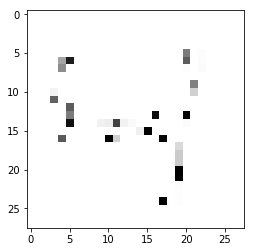

In [33]:
plt.imshow(x_reshape[2][0], cmap='Greys')

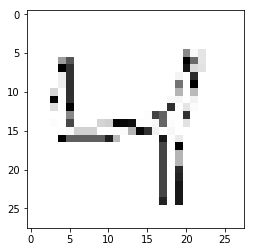

In [34]:
plt.imshow(x_reshape[2][1], cmap='Greys')

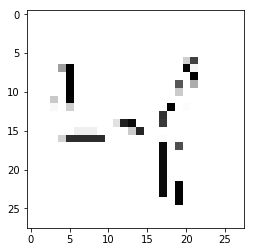

In [35]:
plt.imshow(x_reshape[2][2], cmap='Greys')

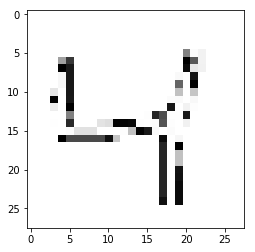

In [36]:
plt.imshow(x_reshape[2][0]+x_reshape[2][2]+x_reshape[2][1], cmap= 'Greys')

In [ ]:
print(np.max(weighted_distance))
print(np.min(weighted_distance))
print(np.average(weighted_distance))
print(np.std(weighted_distance))

In [ ]:
out = output_membership_function(10, weighted_distance)
print(np.max(out))
print(np.min(out))

In [ ]:
print(np.average(out))
print(np.std(out))

In [ ]:
x_train_new = []
for i in x_train[1]:
    x_train_new.append(i*255)
    x_train_new.append(i*255)
    x_train_new.append(i*255)
x_train_new = np.array(x_train_new)
x_train_new.shape
x_train_fuzzy[1].shape
for i in range(len(x_train_fuzzy[1])):
    print(x_train_new[i], end =' ')
    print(x_train_fuzzy[1][i])

In [ ]:
print(y_train.shape)
print(out.shape)

In [ ]:
i = 50
np.set_printoptions(suppress=True)
plt.imshow(x_train[i].reshape(28, 28), cmap='Greys')
print(y_train[i])
print(y_train_fuzzy[i])

In [ ]:
weighted_distance, mean = output_normalize(x_train, y_train)
out = output_membership_function(10, weighted_distance)
i = 50
np.set_printoptions(suppress=True)
plt.imshow(x_train[i].reshape(28, 28), cmap='Greys')
print(y_train[i])
print(out[i])

In [ ]:
i = 25
np.set_printoptions(suppress=True)
plt.imshow(x_train[i].reshape(28, 28), cmap='Greys')
print(y_train[i])
print(out[i])

In [ ]:
maxout = np.max(out, axis = 1)

In [ ]:
count = 0
for i in maxout:
    if i>=0.5:
        count = count + 1

In [ ]:
count